In [6]:
## Notebook example to read the time-series value / coordinate info

% matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pysar.objects import timeseries, deramp
from pysar.utils import readfile, utils as ut

#work_dir = os.path.expanduser('~/insarlab/PYSAR_EXAMPLE/FernandinaSenDT128/PYSAR/GEOCODE')
work_dir = os.path.expanduser('~/iCloud-Drive-Archive/pysar/test_data/FernandinaSenDT128/')
ts_file  = os.path.join(work_dir, 'geo_timeseries_ECMWF_ramp_demErr_masked.h5')
vel_file = os.path.join(work_dir, 'geo_velocity_masked.h5')
mask_file= os.path.join(work_dir, 'geo_maskTempCoh.h5')

ts_obj = timeseries(ts_file)
ts_obj.open()

def get_lat_lon(meta, mask=None):
    """extract lat/lon info of all grids into 2D matrix
    Parameters: meta : dict, including X/Y_FIRST/STEP and LENGTH/WIDTH info
    Returns:    lats : 2D np.array for latitude  in size of (length, width)
                lons : 2D np.array for longitude in size of (length, width)
    """
    # generate 2D matrix for lat/lon
    lat_num = int(meta['LENGTH'])
    lon_num = int(meta['WIDTH'])
    lat0 = float(meta['Y_FIRST'])
    lon0 = float(meta['X_FIRST'])
    lat_step = float(meta['Y_STEP'])
    lon_step = float(meta['X_STEP'])
    lat1 = lat0 + lat_step * lat_num
    lon1 = lon0 + lon_step * lon_num
    lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                          lon0:lon1:lon_num*1j]
    return lats, lons


def get_boxes4deforming_area(vel_file, mask_file, win_size=30, min_percentage=0.2,
                             ramp_type='quadratic', display=False):
    """Get list of boxes to cover the deforming areas. 
    A pixel is identified as deforming if its velocity exceeds the MAD of the whole image.
    Parameters: vel_file : str, path of velocity file
                mask_file : str, path of mask file
                win_size  : int, length and width of the output box
                min_percentage : float between 0 and 1, minimum percentage of deforming points in the box
                ramp_type : str, type of phase ramps to be removed while evaluating the deformation
                display   : bool, plot the identification result or not
    Returns:    box_list  : list of t-tuple of int, each indicating (col0, row0, col1, row1)
    """
    print('-'*30)
    print('get boxes on deforming areas')
    mask = readfile.read(mask_file)[0]
    vel, atr = readfile.read(vel_file)
    print('removing a {} phase ramp from input velocity before the evaluation'.format(ramp_type))
    vel = deramp(vel, mask, ramp_type=ramp_type, metadata=atr)[0]         #remove ramp before the evaluation

    # get deforming pixels
    mad = ut.median_abs_deviation_threshold(vel[mask], center=0., cutoff=3) #deformation threshold
    print('velocity threshold / median abs dev: {:.3f} cm/yr'.format(mad))
    vel[mask == 0] = 0
    mask_aoi = (vel >= mad) + (vel <= -1. * mad)
    print('number of points: {}'.format(np.sum(mask_aoi)))

    # get deforming boxes
    box_list = []
    min_num = min_percentage * (win_size ** 2)
    length, width = vel.shape
    num_row = np.ceil(length / win_size).astype(int)
    num_col = np.ceil(width / win_size).astype(int)
    for i in range(num_row):
        r0 = i * win_size
        r1 = min([length, r0 + win_size])
        for j in range(num_col):
            c0 = j * win_size
            c1 = min([width, c0 + win_size])
            box = (c0, r0, c1, r1)
            if np.sum(mask_aoi[r0:r1, c0:c1]) >= min_num:
                box_list.append(box)
    print('number of boxes : {}'.format(len(box_list)))

    if display:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 8], sharey=True)
        vel[mask == 0] = np.nan
        axs[0].imshow(vel, cmap='jet')
        axs[1].imshow(mask_aoi, cmap='gray')
        for box in box_list:
            for ax in axs:
                rect = Rectangle((box[0],box[1]), (box[2]-box[0]), (box[3]-box[1]), linewidth=2, edgecolor='r', fill=False)
                ax.add_patch(rect)
        plt.show()
    return box_list

open timeseries file: geo_timeseries_ECMWF_ramp_demErr_masked.h5


In [7]:
## read data
# Time
dates = np.array(ts_obj.times)                # 1D np.array of dates in datetime.datetime object in size of [num_date,]

# Velocity / time-series
mask = readfile.read(mask_file)[0]            # matrix indicating valid pixels (True for valid, False for invalid)
vel = readfile.read(vel_file)[0][mask]        # 1D np.array of velocity   in np.float32 in size of [num_pixel,] in meter/year
ts = readfile.read(ts_file)[0][:, mask]       # 2D np.array of time-sries in np.float32 in size of [num_date, num_pixel] in meter

# Spatial coordinates
lats, lons = get_lat_lon(ts_obj.metadata)
lats = lats[mask]                             # 1D np.array of latitude  in np.float32 in size of [num_pixel,] in degree
lons = lons[mask]                             # 1D np.array of longitude in np.float32 in size of [num_pixel,] in degree

In [8]:
# For example, here is the information of the 101 pixel for example
idx = 100
print('Latitude : {} deg'.format(lats[idx]))
print('Longitude: {} deg'.format(lons[idx]))
print('Velocity:', vel[idx])
print('Dates:', dates)
print('Displacement time-series:', ts[:, idx])

Latitude : -0.265259655920761 deg
Longitude: -91.48614171932762 deg
Velocity: 0.000273502
Dates: [datetime.datetime(2014, 12, 13, 0, 0)
 datetime.datetime(2014, 12, 25, 0, 0) datetime.datetime(2015, 3, 7, 0, 0)
 datetime.datetime(2015, 3, 19, 0, 0) datetime.datetime(2015, 3, 31, 0, 0)
 datetime.datetime(2015, 4, 12, 0, 0) datetime.datetime(2015, 4, 24, 0, 0)
 datetime.datetime(2015, 5, 6, 0, 0) datetime.datetime(2015, 5, 18, 0, 0)
 datetime.datetime(2015, 5, 30, 0, 0) datetime.datetime(2015, 6, 11, 0, 0)
 datetime.datetime(2015, 6, 23, 0, 0) datetime.datetime(2015, 7, 17, 0, 0)
 datetime.datetime(2015, 7, 29, 0, 0) datetime.datetime(2015, 8, 22, 0, 0)
 datetime.datetime(2015, 9, 3, 0, 0) datetime.datetime(2015, 9, 15, 0, 0)
 datetime.datetime(2015, 9, 27, 0, 0) datetime.datetime(2015, 10, 9, 0, 0)
 datetime.datetime(2015, 10, 21, 0, 0)
 datetime.datetime(2015, 11, 2, 0, 0)
 datetime.datetime(2015, 11, 14, 0, 0)
 datetime.datetime(2015, 11, 26, 0, 0)
 datetime.datetime(2015, 12, 8, 0, 0

------------------------------
get boxes on deforming areas
removing a quadratic phase ramp from input velocity before the evaluation
velocity threshold / median abs dev: 0.010 cm/yr
number of points: 5890
number of boxes : 13


/Users/joshua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/Users/joshua/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal


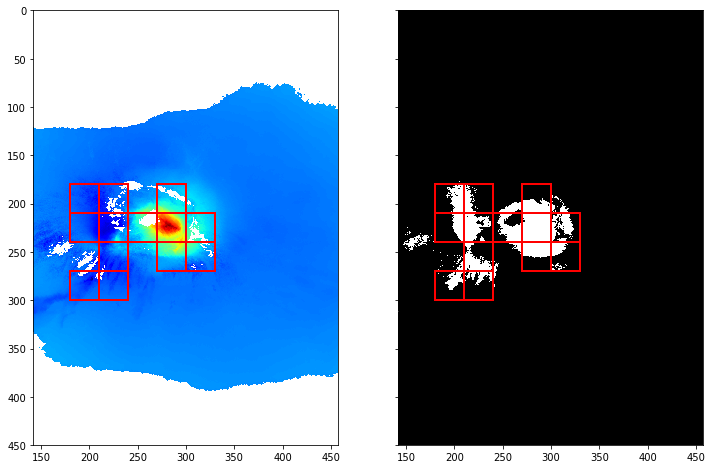

------------------------------
get boxes on deforming areas
removing a quadratic phase ramp from input velocity before the evaluation
velocity threshold / median abs dev: 0.010 cm/yr
number of points: 5890
number of boxes : 13


In [9]:
## Find deforming areas in forms of box
box_list = get_boxes4deforming_area(vel_file, mask_file, display=True)  #test
box_list = get_boxes4deforming_area(vel_file, mask_file, win_size=30)   #use in practice